In [2]:
%reset -f
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import seaborn as sns
import sqlite3
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import numpy as np
from sklearn.metrics import mean_squared_error
from math import sqrt
import RebapCalc
from sklearn.preprocessing import normalize
from sklearn import preprocessing

In [5]:
cnx = sqlite3.connect('Prognosedaten.db')

strSQL = 'Select SRL.TimeStamp as date, Rebap.Price AS Rebap_Preis, NRV.Saldo AS NRV_Saldo, Intraday.Price AS Intraday_Preis,Intraday.Volume AS Intraday_Volumen, SRL.Arbeitspreis_Neg AS SRL_Arbeitspreis_Neg,SRL.Arbeitspreis_Pos AS SRL_Arbeitspreis_Pos,SRL.AbgerMenge_Neg AS SRL_AbgerMenge_Neg,SRL.AbgerMenge_Pos AS SRL_AbgerMenge_Pos, MRL.Arbeitspreis_Neg AS MRL_Arbeitspreis_Neg,MRL.Arbeitspreis_Pos AS MRL_Arbeitspreis_Pos,MRL.AbgerMenge_Neg AS MRL_AbgerMenge_Neg,MRL.AbgerMenge_Pos AS MRL_AbgerMenge_Pos,PV_Ante-PV_Post AS PV_error, WI_Ante-WI_Post AS WI_error,APMax.APMax FROM Rebap, SRL, MRL,Intraday, NRV, RE, APMax WHERE SRL.TimeStamp = APMax.TimeStamp AND SRL.TimeStamp = RE.TimeStamp AND SRL.TimeStamp = Rebap.TimeStamp AND SRL.TimeStamp = MRL.TimeStamp AND SRL.TimeStamp = Intraday.TimeStamp AND SRL.TimeStamp = NRV.TimeStamp AND Rebap.TimeStamp NOT LIKE "%2018%" AND  Rebap.Price is NOT NULL AND NRV.Saldo is NOT NULL AND Intraday.Price is NOT NULL AND Intraday.Volume is NOT NULL AND SRL.Arbeitspreis_Neg is NOT NULL AND SRL.Arbeitspreis_Pos is NOT NULL AND SRL.AbgerMenge_Neg is NOT NULL AND SRL.AbgerMenge_Pos is NOT NULL AND MRL.Arbeitspreis_Neg is NOT NULL AND MRL.Arbeitspreis_Pos is NOT NULL AND MRL.AbgerMenge_Neg is NOT NULL AND MRL.AbgerMenge_Pos is NOT NULL AND PV_Ante is NOT NULL AND PV_Post is NOT NULL AND WI_Ante is NOT NULL AND WI_Post is NOT NULL'



df = pd.read_sql_query(strSQL,cnx)


trend = pd.read_csv("trend.txt") 
print(trend)
#df = df.drop(['SRL_AbgerMenge_Pos', 'SRL_Arbeitspreis_Pos', 'SRL_AbgerMenge_Neg','SRL_Arbeitspreis_Neg','NRV_Saldo'],axis=1)
#print(df.shape)
#print(df.columns)

#adding taxes:)

df.Intraday_Preis    *=1.19
df.SRL_Arbeitspreis_Neg *=1.19
df.SRL_Arbeitspreis_Pos *=1.19
df.MRL_Arbeitspreis_Neg *=1.19
df.MRL_Arbeitspreis_Pos *=1.19


date   seasonal
0       2015-01-01 00:15:00  -2.090542
1       2015-01-01 00:30:00   2.257952
2       2015-01-01 00:45:00  -7.785907
3       2015-01-01 01:00:00 -14.762777
4       2015-01-01 01:15:00 -17.808365
...                     ...        ...
104350  2017-12-31 22:45:00  -4.888860
104351  2017-12-31 23:00:00  -9.797776
104352  2017-12-31 23:15:00  -2.090542
104353  2017-12-31 23:30:00   2.257952
104354  2017-12-31 23:45:00  -7.785907

[104355 rows x 2 columns]


In [6]:
train=df.sample(frac=0.8,random_state=200) #random state is a seed value
test=df.drop(train.index)

print(train.columns)

#Y_MRL_AbgerMenge_Pos = test['MRL_AbgerMenge_Pos'].copy().to_numpy()
#train = train.drop('MRL_AbgerMenge_Pos',axis=1)
#test = test.drop('MRL_AbgerMenge_Pos',axis=1)
#Y_MRL_Arbeitspreis_Pos = test['MRL_Arbeitspreis_Pos'].copy().to_numpy()
#train = train.drop('MRL_Arbeitspreis_Pos',axis=1)
#test = test.drop('MRL_Arbeitspreis_Pos',axis=1)
#Y_MRL_AbgerMenge_Neg = test['MRL_AbgerMenge_Neg'].copy().to_numpy()
#train = train.drop('MRL_AbgerMenge_Neg',axis=1)
#test = test.drop('MRL_AbgerMenge_Neg',axis=1)
#Y_MRL_Arbeitspreis_Neg = test['MRL_Arbeitspreis_Neg'].copy().to_numpy()
#train = train.drop('MRL_Arbeitspreis_Neg',axis=1)
#test = test.drop('MRL_Arbeitspreis_Neg',axis=1)

#rebap_test = (test['Rebap_Preis']).copy().to_numpy()
#rebaptemp = test['Rebap_Preis'].copy().to_numpy()

pdY_train = train['Rebap_Preis'].copy()
pdX_train = train.drop(['Rebap_Preis'], axis=1)

pdY_test = test[['Rebap_Preis']].copy()
pdX_test = test.drop(['Rebap_Preis'], axis=1)

#pdX_train=(pdX_train-pdX_train.min())/(pdX_train.max()-pdX_train.min())
#pdX_test=(pdX_test-pdX_test.min())/(pdX_test.max()-pdX_test.min())

Xtrain = pdX_train.to_numpy()
Ytrain = pdY_train.to_numpy()

Xtest  = pdX_test.to_numpy()
Ytest  = pdY_test.to_numpy()

print(train.shape)
print(pdX_test.columns)
print(pdX_test)
print("Data poccessed starting on the ML stuff")
#print(Xtest[:, [2]])
#plt.plot(Xtest[:, [2]],color='blue',linewidth=0.1)
#plt.show()


Index(['date', 'Rebap_Preis', 'NRV_Saldo', 'Intraday_Preis',
       'Intraday_Volumen', 'SRL_Arbeitspreis_Neg', 'SRL_Arbeitspreis_Pos',
       'SRL_AbgerMenge_Neg', 'SRL_AbgerMenge_Pos', 'MRL_Arbeitspreis_Neg',
       'MRL_Arbeitspreis_Pos', 'MRL_AbgerMenge_Neg', 'MRL_AbgerMenge_Pos',
       'PV_error', 'WI_error', 'APMax'],
      dtype='object')
(83484, 16)
Index(['date', 'NRV_Saldo', 'Intraday_Preis', 'Intraday_Volumen',
       'SRL_Arbeitspreis_Neg', 'SRL_Arbeitspreis_Pos', 'SRL_AbgerMenge_Neg',
       'SRL_AbgerMenge_Pos', 'MRL_Arbeitspreis_Neg', 'MRL_Arbeitspreis_Pos',
       'MRL_AbgerMenge_Neg', 'MRL_AbgerMenge_Pos', 'PV_error', 'WI_error',
       'APMax'],
      dtype='object')
                       date  NRV_Saldo  Intraday_Preis  Intraday_Volumen  \
3       2015-01-01 01:00:00    460.380         57.1795             203.7   
4       2015-01-01 01:15:00    502.827         34.3910              44.6   
14      2015-01-01 03:45:00   -145.705         14.7441             105.6   
1

In [4]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5)

In [5]:
def get_model():

	model = tf.keras.Sequential()
	model.add(tf.keras.layers.Dense(90, activation='relu', input_shape=[Xtrain.shape[1]]))
	model.add(keras.layers.Dense(90, activation='relu'))
	model.add(keras.layers.Dense(90, activation='relu'))
	model.add(keras.layers.Dense(90, activation='relu'))
	model.add(keras.layers.Dense(90, activation='relu'))
	model.add(keras.layers.Dense(90, activation='relu'))
	model.add(keras.layers.Dense(90, activation='relu'))
	model.add(tf.keras.layers.Dense(1))
	
	sgd = tf.optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
	rmspop = tf.keras.optimizers.RMSprop(0.001)#chills at 2.3
	model.compile(optimizer=rmspop,loss='mean_squared_error')
	return model

In [6]:
model = get_model()
_ = model.fit(Xtrain,Ytrain,
	batch_size=64,
	epochs=50,
	#steps_per_epoch=5,
	verbose=1,
	validation_data = (Xtest,Ytest))
	#callbacks=[callback])
#print(pdX_train)

Epoch 1/50
1305/1305 [==============================] - 7s 6ms/step - loss: 23278.1699 - val_loss: 8662.1348
Epoch 2/50
1305/1305 [==============================] - 9s 7ms/step - loss: 22410.9648 - val_loss: 8136.4570
Epoch 3/50
1305/1305 [==============================] - 9s 7ms/step - loss: 23556.3750 - val_loss: 7414.5288
Epoch 4/50
1305/1305 [==============================] - 10s 8ms/step - loss: 18449.0703 - val_loss: 7350.7539
Epoch 5/50
1305/1305 [==============================] - 10s 8ms/step - loss: 16476.7285 - val_loss: 7556.5215
Epoch 6/50
1305/1305 [==============================] - 11s 8ms/step - loss: 20593.7812 - val_loss: 7007.6621
Epoch 7/50
1305/1305 [==============================] - 11s 8ms/step - loss: 19565.1641 - val_loss: 6725.0396
Epoch 8/50
1305/1305 [==============================] - 11s 8ms/step - loss: 16254.2393 - val_loss: 7036.6987
Epoch 9/50
1305/1305 [==============================] - 11s 8ms/step - loss: 18741.6875 - val_loss: 5980.6665
Epoch 10/50
1

RMS: 
78.09759092010134
%diff
84.90728762397585


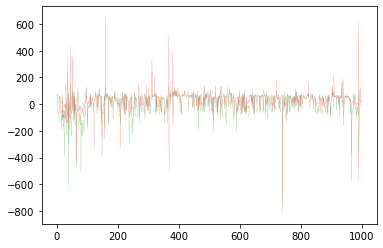

In [7]:
predictions = model.predict(Xtest)

#truth = Y_MRL_Arbeitspreis_Pos >= predictions
#for i in range(truth.shape[0]):
#    if (truth[0][i]):
#        predictions[i] = Y_MRL_Arbeitspreis_Pos[i]

differences = predictions*Ytest
truth = (differences >  0)

rms = sqrt(mean_squared_error(predictions, Ytest))
print("RMS: ")
print(rms)
print("%diff")
print(100*(np.sum(truth)/predictions.shape[0]))
truth = truth*1000
plt.plot(predictions[:1000],color='green',linewidth=0.1)
plt.plot(Ytest[:1000],color='red',linewidth=0.1)
#plt.plot(Xtest[:1000, [0]],color='yellow',linewidth=0.1)
#plt.plot(Y_MRL_AbgerMenge_Pos[:1000],color='blue',linewidth=0.1)
#plt.plot(Y_MRL_Arbeitspreis_Neg[:1000],color='yellow',linewidth=0.1)
#plt.plot(Y_MRL_AbgerMenge_Neg[:1000],color='blue',linewidth=0.1)
plt.show()





In [8]:
data = np.array([[1, 2], [3,4], [5,6], [7,8]])
print(data)


# Creating pandas dataframe from numpy array
dataset = pd.DataFrame({'Column1': data[:, 0],'Column2': data[:, 1]})
print(dataset)
dataset.Column1 *=5.44
print(dataset)

#print(dataset.sample(frac=0.8,random_state=200))

#normed_matrix = normalize(et, axis=0, norm='l1')

#df.sample(frac=0.8,random_state=200)


[[1 2]
 [3 4]
 [5 6]
 [7 8]]
   Column1  Column2
0        1        2
1        3        4
2        5        6
3        7        8
   Column1  Column2
0     5.44        2
1    16.32        4
2    27.20        6
3    38.08        8


In [16]:
df1 = pd.DataFrame(np.random.randint(0,5,size=(4, 4)), columns=list('ABCD'))
df2 = pd.DataFrame(np.random.randint(0,5,size=(4, 4)), columns=list('ABCD'))

for i in range(0,4):
    df1['A'][i] = i;
    df2['A'][i] = i;


print(df1)
print(df2)


df1.reset_index('A', drop=False).join(df2.rename_axis('a1').set_index('a2', append=True)

print(df1)

A  B  C  D
0  0  1  2  3
1  1  4  4  4
2  2  3  2  2
3  3  3  2  2
   A  B  C  D
0  0  1  2  2
1  1  4  3  1
2  2  1  2  1
3  3  3  0  4
